In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 기본 준비

In [2]:
import pandas as pd
import numpy as np
import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import Binarizer
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [4]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [150]:
# 오차행렬 및 평가지표 출력
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = 0
    
    if pred_proba is not None:
        roc_auc = roc_auc_score(y_test, pred_proba)
    # roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


# 임계값 조정하여 오차행렬 및 평가지표 출력
def get_eval_by_threshold(y_test, pred, pred_proba_c1, thresholds):
    pred_proba_c1 = pred_proba_c1.reshape(-1, 1)
    for custom_threshold in thresholds:
        binar = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binar.transform(pred_proba_c1)
        print("분류 임계값:", custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
    

# 임계값별로 precison_recall_curve 그리기
def precision_recall_curve_plot(y_test, pred_proba_c1): 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]

    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') 
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [6]:
def make_eval_df(model):
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    confusion = str(confusion_matrix(y_test, pred)).replace("\n", "").replace("[ ", "[")
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    try:
        pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, pred_proba)
    except:
        roc_auc = 0
    
    return pd.DataFrame([{"model": str(model).replace("\n", ""), 
                          "params": str(model.get_params()),
                          "confusion": confusion,
                          "accuracy": accuracy,
                          "precision": precision,
                          "recall": recall,
                          "f1": f1,
                          "roc_auc": roc_auc}])

col_list = ["model", "params", "confusion", "accuracy", "precision", "recall", "f1", "roc_auc"]

## 데이터 준비

In [10]:
data_path = "/content/drive/MyDrive/multicampus/data/"

In [8]:
def prepare_data_smote():
    brfss = pd.read_csv(data_path + "brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(y_train.value_counts())
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

In [ ]:
def prepare_data_adasyn():
    brfss = pd.read_csv("../data/brfss.csv")
    X = brfss.drop(["HEARTDISEASE", "ALCOHOL"], axis=1)
    y = brfss["HEARTDISEASE"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    adasyn = ADASYN()
    X_train, y_train = adasyn.fit_resample(X_train, y_train)

    print(y_train.value_counts())
    print(y_test.value_counts())

    return X_train, X_test, y_train, y_test

# 할 일
- 하이퍼 파라미터 튜닝
    - 각 모델 document 보면서 찾아보기
- 임계점 변경
    - 변경해보면서 최적값 찾기

# 박민정

## Data
- 건강검진 데이터의 KIDNEY 조건 변경 검토
```
data["KIDNEY"] = data.apply(lambda x: 1 if x["요단백"]>=3 or x["혈청크레아티닌"]>1.7 or x["혈청크레아티닌"]<0.8 else 0, axis=1)
0    1295062
1     744182
```
```
data["KIDNEY"] = data.apply(lambda x: 1 if x["요단백"]>=3 and (x["혈청크레아티닌"]>1.7 or x["혈청크레아티닌"]<0.8) else 0, axis=1)
0    2020722
1      18522
```

## DecisionTree

### 모델링
- 하이퍼 파라미터  
    - **ccp_alpha**
        - .0, .015, .03, .045
        - .0, .0001, .0005
    - **class_weight**
        - "balanced", None
    - **criterion**: 
        - "gini", "entropy", "log_loss"
    - **max_depth**
        - 5, 10, 15, 20
        - 5, 6, 7
    - **max_features**
        - "sqrt", "log2", None
    - **min_impurity_decrease**
        - .0001, .0004, .0007, .001, .0013
        - .0001, .0002, .0006, .0008

- 사용하지 않은 하이퍼 파라미터
    - min_samples_leaf
        - 1, 5, 10, 15
    - min_samples_split
        - 2, 20, 40, 60, 80, 100


- 선택한 모델
    1. ```DecisionTreeClassifier(ccp_alpha=0.0005, class_weight=None, criterion='entropy', max_depth=5, max_features='log2', min_impurity_decrease=0.0002)```
    2. ```DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='gini', max_depth=5, max_features='log2', min_impurity_decrease=0.0006)```
    3. ```DecisionTreeClassifier(ccp_alpha=0.0005, class_weight='balanced', criterion='gini', max_depth=7, max_features='log2', min_impurity_decrease=0.0006)```

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
max_depth_list = [5, 10, 15, 20]
min_samples_split_list = [2, 20, 40, 60, 80, 100]
min_samples_leaf_list = [1, 5, 10, 15]
min_impurity_decrease_list = [.0001, .0004, .0007, .001, .0013]
ccp_alpha_list = [.0, .015, .03, .045]


dt_df = pd.DataFrame(columns=col_list)

X_train, X_test, y_train, y_test = prepare_data_smote()

for max_depth in tqdm(max_depth_list, desc="max_depth"):
    for min_samples_split in tqdm(min_samples_split_list, desc="min_samples_split"):
        for min_samples_leaf in tqdm(min_samples_leaf_list, desc="min_samples_leaf"):
            for min_impurity_decrease in tqdm(min_impurity_decrease_list, desc="min_impurity_decrease"):
                for ccp_alpha in tqdm(ccp_alpha_list, desc="ccp_alpha"):
                    model = DecisionTreeClassifier(max_depth=max_depth,
                                                   min_samples_split=min_samples_split,
                                                   min_samples_leaf=min_samples_leaf,
                                                   min_impurity_decrease=min_impurity_decrease,
                                                   ccp_alpha=ccp_alpha)
                    dt_df = pd.concat([dt_df, make_eval_df(model)], axis=0, ignore_index=True)

0.0    286845
1.0    286845
Name: HEARTDISEASE, dtype: int64
0.0    71579
1.0     4151
Name: HEARTDISEASE, dtype: int64


max_depth:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_split:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_split:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_split:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_split:   0%|          | 0/6 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_samples_leaf:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/5 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
dt_df.to_csv("./DecisionTree_1.csv", index=False)

In [ ]:
dt_result = pd.read_csv("./DecisionTree_1.csv")
dt_result = dt_result.sort_values("precision", ascending=False)
dt_result["precision"].unique()

array([0.12517241, 0.12461344, 0.12334895, 0.11324182, 0.11251263,
       0.10386188])

---

In [ ]:
max_depth_list = [5, 6, 7, 8, 9, 10]
min_impurity_decrease_list = [.0001, .0002, .0006, .0008]
ccp_alpha_list = [.0, .0001, .0005]

criterion_list = ["gini", "entropy", "log_loss"]
max_features_list = ["sqrt", "log2", None]
class_weight_list = ["balanced", None]

dt_df = pd.DataFrame(columns=col_list)

X_train, X_test, y_train, y_test = prepare_data_smote()

for max_depth in tqdm(max_depth_list, desc="max_depth"):
    for min_impurity_decrease in tqdm(min_impurity_decrease_list, desc="min_impurity_decrease"):
        for ccp_alpha in tqdm(ccp_alpha_list, desc="ccp_alpha"):
            for criterion in tqdm(criterion_list, desc="criterion"):
                for max_features in tqdm(max_features_list, desc="max_features"):
                    for class_weight in tqdm(class_weight_list, desc="class_weight"):
                        model = DecisionTreeClassifier(max_depth=max_depth,
                                                       min_impurity_decrease=min_impurity_decrease,
                                                       ccp_alpha=ccp_alpha,
                                                       criterion=criterion,
                                                       max_features=max_features,
                                                       class_weight=class_weight)
                        dt_df = pd.concat([dt_df, make_eval_df(model)], axis=0, ignore_index=True)

print(len(dt_df))

0.0    286751
1.0    286751
Name: HEARTDISEASE, dtype: int64
0.0    71673
1.0     4057
Name: HEARTDISEASE, dtype: int64


max_depth:   0%|          | 0/6 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

min_impurity_decrease:   0%|          | 0/4 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

ccp_alpha:   0%|          | 0/3 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

criterion:   0%|          | 0/3 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

max_features:   0%|          | 0/3 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

1296


In [ ]:
dt_df.to_csv("./DecisionTree_2.csv", index=False)

### 임계값 변경
- 의료 데이터이므로 높이는 쪽으로

#### 모델 선택

In [203]:
dt_result = pd.read_csv(data_path + "DecisionTree_1.csv")
dt_result = dt_result.sort_values("precision", ascending=False)

In [216]:
max_depth_list = [5, 10, 15, 20]
min_samples_split_list = [2, 20, 40, 60, 80, 100]
min_samples_leaf_list = [1, 5, 10, 15]
min_impurity_decrease_list = [.0, .0001, .001, .01]
ccp_alpha_list = [.0, .0001, .001, .01]

for i in ccp_alpha_list:
    print(dt_result[dt_result["model"].str.contains(f"ccp_alpha={i}")]["precision"].mean())

0.10901730662482631
0.11221335658872407
0.11533226173106474
0.0995063015546901


In [221]:
dt_temp = dt_result[dt_result["precision"]>.12]

max_depth_list = [5, 10, 15, 20]
min_samples_split_list = [2, 20, 40, 60, 80, 100]
min_samples_leaf_list = [1, 5, 10, 15]
min_impurity_decrease_list = [.0, .0001, .001, .01]
ccp_alpha_list = [.0, .0001, .001, .01]

for i in max_depth_list:
    print(dt_temp[dt_temp["model"].str.contains(f"max_depth={i}")]["precision"].mean())

0.12204358915175477
0.12060758178985626
0.12060758178985626
0.12060758178985626


In [224]:
dt_result = pd.read_csv(data_path + "DecisionTree_2.csv")
dt_result = dt_result.sort_values("precision", ascending=False)

In [225]:
max_depth_list = [2, 4, 6, 8, 10]
min_impurity_decrease_list = [.0001, .0002, .0004, .0006, .0008, .001]
ccp_alpha_list = [.0001, .0002, .0004, .0006, .0008, .001]

for i in max_depth_list:
    print(dt_result[dt_result["model"].str.contains(f"max_depth={i}")]["precision"].mean())
print("===")
for i in min_impurity_decrease_list:
    print(dt_result[dt_result["model"].str.contains(f"min_impurity_decrease={i}")]["precision"].mean())
print("===")
for i in ccp_alpha_list:
    print(dt_result[dt_result["model"].str.contains(f"ccp_alpha={i}")]["precision"].mean())

0.09891577868215852
0.12082768275077647
0.12048028443057923
0.11786966291025765
0.11786966291025765
===
0.11432250537346514
0.11434609767529615
0.11388460112848721
0.11607858995326709
0.11607858995326709
0.11644530193705292
===
0.11432250537346514
0.11434609767529615
0.11388460112848721
0.11607858995326709
0.11607858995326709
0.11644530193705292


In [227]:
dt_temp = dt_result[dt_result["precision"]>.1]
print(len(dt_temp))
print("===")
max_depth_list = [2, 4, 6, 8, 10]
min_impurity_decrease_list = [.0001, .0002, .0004, .0006, .0008, .001]
ccp_alpha_list = [.0001, .0002, .0004, .0006, .0008, .001]

for i in max_depth_list:
    print(dt_temp[dt_temp["model"].str.contains(f"max_depth={i}")]["precision"].mean())
print("===")
for i in min_impurity_decrease_list:
    print(dt_temp[dt_temp["model"].str.contains(f"min_impurity_decrease={i}")]["precision"].mean())
print("===")
for i in ccp_alpha_list:
    print(dt_temp[dt_temp["model"].str.contains(f"ccp_alpha={i}")]["precision"].mean())

144
===
nan
0.12082768275077647
0.12048028443057923
0.11786966291025765
0.11786966291025765
===
0.11817418704629178
0.11820367742358052
0.11762680674006935
0.1203692927710442
0.1203692927710442
0.1208276827507765
===
0.11817418704629178
0.11820367742358052
0.11762680674006935
0.1203692927710442
0.1203692927710442
0.1208276827507765


In [228]:
dt_result = pd.read_csv(data_path + "DecisionTree_3.csv")
dt_result = dt_result.sort_values("precision", ascending=False)

In [239]:
dt_temp = dt_result[(dt_result["precision"]>.13)]# & (dt_result["accuracy"]>.75) & (dt_result["recall"]>.5)]
len(dt_temp)

3

In [240]:
dt_temp

,model,params,confusion,accuracy,precision,recall,f1,roc_auc
141,"DecisionTreeClassifier(criterion='log_loss', max_depth=5, max_features='sqrt', min_impurity_decrease=0.001)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[56641 15007] [1715 2367]],0.779189,0.136238,0.579863,0.220638,0.747484
28,"DecisionTreeClassifier(max_depth=4, max_features='log2', min_impurity_decrease=0.0005)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[58867 12781] [2093 1989]],0.803592,0.134665,0.487261,0.211012,0.734678
15,"DecisionTreeClassifier(ccp_alpha=0.0005, criterion='log_loss', max_depth=4, max_features='sqrt')","{'ccp_alpha': 0.0005, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[54796 16852] [1557 2525]],0.756913,0.130309,0.618569,0.215269,0.713577


#### 임계값

In [167]:
dt_result = pd.read_csv(data_path + "DecisionTree_final.csv")
dt_result = dt_result.sort_values("precision", ascending=False)

In [168]:
X_train, X_test, y_train, y_test = prepare_data_smote()

0.0    286768
1.0    286768
Name: HEARTDISEASE, dtype: int64
0.0    71656
1.0     4074
Name: HEARTDISEASE, dtype: int64


##### model1

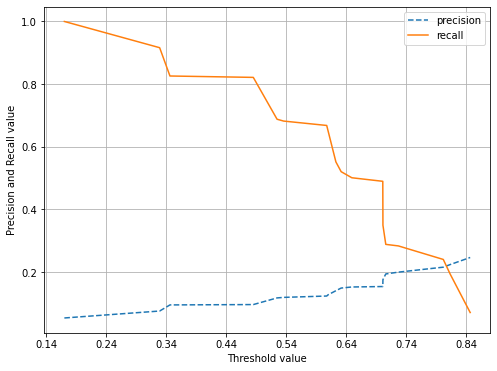

In [177]:
model = eval(dt_result.loc[0, "model"])

model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

precision_recall_curve_plot(y_test, pred_proba)

In [138]:
thresholds = np.arange(.77, .82, .01) # .80
get_eval_by_threshold(y_test, pred, pred_proba, thresholds)
"""
분류 임계값: 0.79
오차 행렬
[[67230  4430]
 [ 3059  1011]]
정확도: 0.9011, 정밀도: 0.1858, 재현율: 0.2484, F1: 0.2126, AUC:0.7373
분류 임계값: 0.8
오차 행렬
[[69675  1985]
 [ 3597   473]]
정확도: 0.9263, 정밀도: 0.1924, 재현율: 0.1162, F1: 0.1449, AUC:0.7373
"""

분류 임계값: 0.77
오차 행렬
[[67230  4430]
 [ 3059  1011]]
정확도: 0.9011, 정밀도: 0.1858, 재현율: 0.2484, F1: 0.2126, AUC:0.7373
분류 임계값: 0.78
오차 행렬
[[67230  4430]
 [ 3059  1011]]
정확도: 0.9011, 정밀도: 0.1858, 재현율: 0.2484, F1: 0.2126, AUC:0.7373
분류 임계값: 0.79
오차 행렬
[[67230  4430]
 [ 3059  1011]]
정확도: 0.9011, 정밀도: 0.1858, 재현율: 0.2484, F1: 0.2126, AUC:0.7373
분류 임계값: 0.8
오차 행렬
[[69675  1985]
 [ 3597   473]]
정확도: 0.9263, 정밀도: 0.1924, 재현율: 0.1162, F1: 0.1449, AUC:0.7373
분류 임계값: 0.81
오차 행렬
[[69675  1985]
 [ 3597   473]]
정확도: 0.9263, 정밀도: 0.1924, 재현율: 0.1162, F1: 0.1449, AUC:0.7373


##### model2

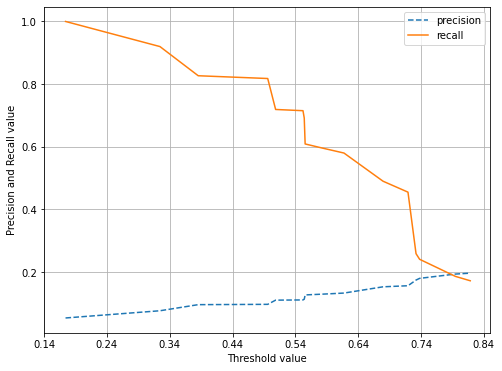

In [134]:
model = eval(dt_result.loc[1, "model"])

model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

precision_recall_curve_plot(y_test, pred_proba)

In [136]:
thresholds = np.arange(.74, .84, .01) # .80
get_eval_by_threshold(y_test, pred, pred_proba, thresholds)
"""
분류 임계값: 0.79
오차 행렬
[[68504  3156]
 [ 3311   759]]
정확도: 0.9146, 정밀도: 0.1939, 재현율: 0.1865, F1: 0.1901, AUC:0.7557
분류 임계값: 0.8
오차 행렬
[[68794  2866]
 [ 3368   702]]
정확도: 0.9177, 정밀도: 0.1967, 재현율: 0.1725, F1: 0.1838, AUC:0.7557
"""

분류 임계값: 0.74
오차 행렬
[[68504  3156]
 [ 3311   759]]
정확도: 0.9146, 정밀도: 0.1939, 재현율: 0.1865, F1: 0.1901, AUC:0.7557
분류 임계값: 0.75
오차 행렬
[[68504  3156]
 [ 3311   759]]
정확도: 0.9146, 정밀도: 0.1939, 재현율: 0.1865, F1: 0.1901, AUC:0.7557
분류 임계값: 0.76
오차 행렬
[[68504  3156]
 [ 3311   759]]
정확도: 0.9146, 정밀도: 0.1939, 재현율: 0.1865, F1: 0.1901, AUC:0.7557
분류 임계값: 0.77
오차 행렬
[[68504  3156]
 [ 3311   759]]
정확도: 0.9146, 정밀도: 0.1939, 재현율: 0.1865, F1: 0.1901, AUC:0.7557
분류 임계값: 0.78
오차 행렬
[[68504  3156]
 [ 3311   759]]
정확도: 0.9146, 정밀도: 0.1939, 재현율: 0.1865, F1: 0.1901, AUC:0.7557
분류 임계값: 0.79
오차 행렬
[[68504  3156]
 [ 3311   759]]
정확도: 0.9146, 정밀도: 0.1939, 재현율: 0.1865, F1: 0.1901, AUC:0.7557
분류 임계값: 0.8
오차 행렬
[[68794  2866]
 [ 3368   702]]
정확도: 0.9177, 정밀도: 0.1967, 재현율: 0.1725, F1: 0.1838, AUC:0.7557
분류 임계값: 0.81
오차 행렬
[[68794  2866]
 [ 3368   702]]
정확도: 0.9177, 정밀도: 0.1967, 재현율: 0.1725, F1: 0.1838, AUC:0.7557
분류 임계값: 0.8200000000000001


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


오차 행렬
[[71660     0]
 [ 4070     0]]
정확도: 0.9463, 정밀도: 0.0000, 재현율: 0.0000, F1: 0.0000, AUC:0.7557
분류 임계값: 0.8300000000000001
오차 행렬
[[71660     0]
 [ 4070     0]]
정확도: 0.9463, 정밀도: 0.0000, 재현율: 0.0000, F1: 0.0000, AUC:0.7557


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### model3


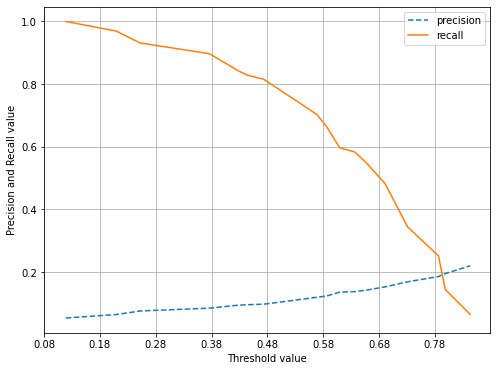

In [148]:
model = eval(dt_result.loc[2, "model"])

model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

precision_recall_curve_plot(y_test, pred_proba)

In [151]:
thresholds = np.arange(.74, .83, .01) # .76
get_eval_by_threshold(y_test, pred, pred_proba, thresholds)

분류 임계값: 0.74
오차 행렬
[[67178  4482]
 [ 3046  1024]]
정확도: 0.9006, 정밀도: 0.1860, 재현율: 0.2516, F1: 0.2139, AUC:0.7648
분류 임계값: 0.75
오차 행렬
[[67178  4482]
 [ 3046  1024]]
정확도: 0.9006, 정밀도: 0.1860, 재현율: 0.2516, F1: 0.2139, AUC:0.7648
분류 임계값: 0.76
오차 행렬
[[67178  4482]
 [ 3046  1024]]
정확도: 0.9006, 정밀도: 0.1860, 재현율: 0.2516, F1: 0.2139, AUC:0.7648
분류 임계값: 0.77
오차 행렬
[[67178  4482]
 [ 3046  1024]]
정확도: 0.9006, 정밀도: 0.1860, 재현율: 0.2516, F1: 0.2139, AUC:0.7648
분류 임계값: 0.78
오차 행렬
[[67178  4482]
 [ 3046  1024]]
정확도: 0.9006, 정밀도: 0.1860, 재현율: 0.2516, F1: 0.2139, AUC:0.7648
분류 임계값: 0.79
오차 행렬
[[69234  2426]
 [ 3481   589]]
정확도: 0.9220, 정밀도: 0.1954, 재현율: 0.1447, F1: 0.1663, AUC:0.7648
분류 임계값: 0.8
오차 행렬
[[70722   938]
 [ 3805   265]]
정확도: 0.9374, 정밀도: 0.2203, 재현율: 0.0651, F1: 0.1005, AUC:0.7648
분류 임계값: 0.81
오차 행렬
[[70722   938]
 [ 3805   265]]
정확도: 0.9374, 정밀도: 0.2203, 재현율: 0.0651, F1: 0.1005, AUC:0.7648
분류 임계값: 0.8200000000000001
오차 행렬
[[70722   938]
 [ 3805   265]]
정확도: 0.9374, 정밀도: 0.2203, 재현율: 0.0651, F1

In [146]:
dt_result[["model", "params"]]

,model,params
0,"DecisionTreeClassifier(ccp_alpha=0.0005, criterion='entropy', max_depth=5, max_features='log2', min_impurity_decrease=0.0002)","{'ccp_alpha': 0.0005, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0002, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}"
1,"DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=5, max_features='log2', min_impurity_decrease=0.0006)","{'ccp_alpha': 0.0001, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0006, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}"
2,"DecisionTreeClassifier(ccp_alpha=0.0005, class_weight='balanced', max_depth=7, max_features='log2', min_impurity_decrease=0.0006)","{'ccp_alpha': 0.0005, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0006, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}"


In [188]:
data_path = "/content/drive/MyDrive/multicampus/data/" 
save_path = "/content/drive/MyDrive/multicampus/data/"

In [189]:
dt_result = pd.read_csv(save_path + "DecisionTree_2.csv")
dt_result = dt_result.sort_values("precision", ascending=False)
dt_result["precision"].unique()

array([0.14287946, 0.14024009, 0.13505147, 0.13411476, 0.1302578 ,
       0.13009272, 0.12806054, 0.12783297, 0.1256729 , 0.12560412,
       0.1252098 , 0.12478959, 0.12476446, 0.12452759, 0.12449471,
       0.12438413, 0.1242675 , 0.12426379, 0.12405523, 0.12368626,
       0.12366106, 0.12350687, 0.1234808 , 0.12307692, 0.12296275,
       0.1226454 , 0.12240874, 0.12229501, 0.12226709, 0.1222233 ,
       0.12217323, 0.12216838, 0.12205794, 0.12205464, 0.12197687,
       0.12195994, 0.12190912, 0.12176818, 0.12168257, 0.12166593,
       0.12162286, 0.12158458, 0.12149328, 0.12144751, 0.12142266,
       0.12134731, 0.1213232 , 0.12125955, 0.12118913, 0.12111532,
       0.12103981, 0.12101166, 0.12095568, 0.12089579, 0.12084987,
       0.12084223, 0.12065641, 0.12050164, 0.12044223, 0.12043349,
       0.12013097, 0.12013071, 0.12008165, 0.11987612, 0.11976203,
       0.11967605, 0.11960819, 0.11954752, 0.11943855, 0.11938586,
       0.1193614 , 0.11930289, 0.11926374, 0.11903954, 0.11893

In [191]:
dt_temp = dt_result[dt_result["precision"]>.125]

In [192]:
len(dt_temp)

11

In [193]:
dt_temp

,model,params,confusion,accuracy,precision,recall,f1,roc_auc
102,"DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=4, max_features='sqrt', min_impurity_decrease=0.0004)","{'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0004, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[60767 10972] [2162 1829]],0.826568,0.142879,0.458281,0.217842,0.725462
229,"DecisionTreeClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=5, max_features='log2', min_impurity_decrease=0.0002)","{'ccp_alpha': 0.0001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0002, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[59349 12390] [1970 2021]],0.810379,0.140240,0.506389,0.219650,0.720447
115,"DecisionTreeClassifier(criterion='log_loss', max_depth=4, max_features='log2', min_impurity_decrease=0.0006)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0006, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[59724 12015] [2115 1876]],0.813416,0.135051,0.470058,0.209820,0.725651
4,"DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='log2', min_impurity_decrease=0.0001)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[59033 12706] [2023 1968]],0.805506,0.134115,0.493109,0.210876,0.732115
342,"DecisionTreeClassifier(ccp_alpha=0.0005, max_depth=5, max_features='sqrt', min_impurity_decrease=0.0008)","{'ccp_alpha': 0.0005, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0008, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[55714 16025] [1591 2400]],0.767384,0.130258,0.601353,0.214133,0.748962
109,"DecisionTreeClassifier(max_depth=4, max_features='log2', min_impurity_decrease=0.0006)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0006, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[59355 12384] [2139 1852]],0.808227,0.130093,0.464044,0.203215,0.689415
447,"DecisionTreeClassifier(ccp_alpha=0.0001, criterion='log_loss', max_depth=6, max_features='sqrt', min_impurity_decrease=0.0004)","{'ccp_alpha': 0.0001, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0004, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[54111 17628] [1402 2589]],0.748713,0.128061,0.648710,0.213896,0.763214
258,"DecisionTreeClassifier(criterion='log_loss', max_depth=5, max_features='sqrt', min_impurity_decrease=0.0004)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0004, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[57077 14662] [1842 2149]],0.782068,0.127833,0.538462,0.206615,0.712384
498,"DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=6, max_features='sqrt', min_impurity_decr

In [197]:
min_impurity_decrease_list = [.0001, .0002, .0004, .0006, .0008]
for i in min_impurity_decrease_list:
    c = dt_df[dt_df["params"].str.contains(str(i))]
    print(i, len(c))
    print(c["precision"].mean())

0.0001 3
0.12708281542443425
0.0002 3
0.12834922754298964
0.0004 0
nan
0.0006 2
0.127130613504416
0.0008 2
0.1281932875747372


In [201]:
dt_result = pd.read_csv(save_path + "DecisionTree_3.csv")
dt_result = dt_result.sort_values("precision", ascending=False)

In [202]:
dt_temp = dt_result[dt_result["precision"]>.125]
dt_temp

,model,params,confusion,accuracy,precision,recall,f1,roc_auc
6,"DecisionTreeClassifier(criterion='log_loss', max_depth=4, max_features='sqrt', min_impurity_decrease=0.0001)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[61475 10292] [2262 1701]],0.834227,0.141833,0.429220,0.213211,0.695069
69,"DecisionTreeClassifier(ccp_alpha=0.0005, criterion='log_loss', max_depth=5, max_features='sqrt', min_impurity_decrease=0.0001)","{'ccp_alpha': 0.0005, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[54929 16838] [1502 2461]],0.757824,0.127520,0.620994,0.211590,0.734520
70,"DecisionTreeClassifier(ccp_alpha=0.0005, criterion='log_loss', max_depth=5, max_features='log2', min_impurity_decrease=0.0001)","{'ccp_alpha': 0.0005, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[54727 17040] [1496 2467]],0.755236,0.126467,0.622508,0.210226,0.743708
4,"DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='log2', min_impurity_decrease=0.0001)","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[57661 14106] [1934 2029]],0.788195,0.125751,0.511986,0.201911,0.713456
19,"DecisionTreeClassifier(ccp_alpha=0.001, max_depth=4, max_features='log2', min_impurity_decrease=0.0001)","{'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}",[[58099 13668] [2006 1957]],0.793028,0.125248,0.493818,0.199816,0.693747


## SGDClassifier

### base model

In [ ]:
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test = prepare_data()

model = SGDClassifier(loss="log_loss", max_iter=10)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]


get_clf_eval(y_test, pred, pred_proba)

0.0    286718
1.0    286718
Name: HEARTDISEASE, dtype: int64
0.0    71706
1.0     4024
Name: HEARTDISEASE, dtype: int64
0.7057736172824867
0.7274263832034861
오차 행렬
[[52340 19366]
 [ 1276  2748]]
정확도: 0.7274, 정밀도: 0.1243, 재현율: 0.6829, F1: 0.2103, AUC:0.7740


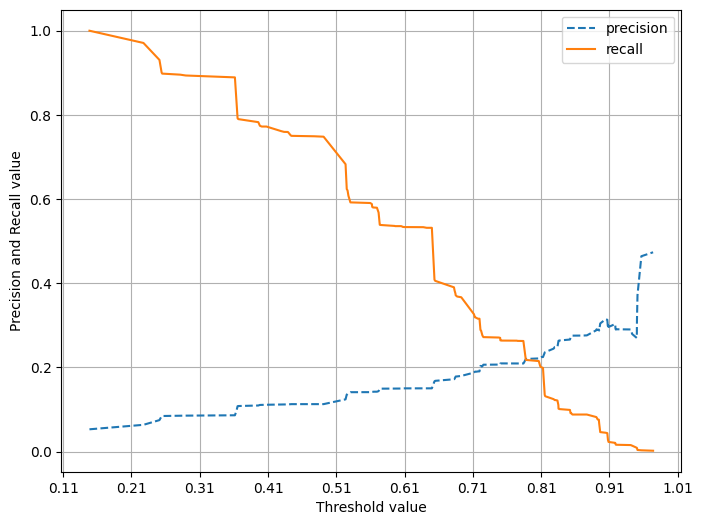

In [ ]:
precision_recall_curve_plot(y_test, pred_proba)

In [ ]:
# 임계값 조정
thresholds = [.75, .76, .77, .78, .79, .80, .81]
get_eval_by_threshold(y_test, pred, pred_proba, thresholds)

분류 임계값: 0.75
오차 행렬
[[67694  4012]
 [ 2960  1064]]
정확도: 0.9079, 정밀도: 0.2096, 재현율: 0.2644, F1: 0.2338, AUC:0.7740
분류 임계값: 0.76
오차 행렬
[[67704  4002]
 [ 2963  1061]]
정확도: 0.9080, 정밀도: 0.2096, 재현율: 0.2637, F1: 0.2335, AUC:0.7740
분류 임계값: 0.77
오차 행렬
[[67704  4002]
 [ 2963  1061]]
정확도: 0.9080, 정밀도: 0.2096, 재현율: 0.2637, F1: 0.2335, AUC:0.7740
분류 임계값: 0.78
오차 행렬
[[67713  3993]
 [ 2966  1058]]
정확도: 0.9081, 정밀도: 0.2095, 재현율: 0.2629, F1: 0.2332, AUC:0.7740
분류 임계값: 0.79
오차 행렬
[[68662  3044]
 [ 3158   866]]
정확도: 0.9181, 정밀도: 0.2215, 재현율: 0.2152, F1: 0.2183, AUC:0.7740
분류 임계값: 0.8
오차 행렬
[[68662  3044]
 [ 3158   866]]
정확도: 0.9181, 정밀도: 0.2215, 재현율: 0.2152, F1: 0.2183, AUC:0.7740
분류 임계값: 0.81
오차 행렬
[[68943  2763]
 [ 3223   801]]
정확도: 0.9210, 정밀도: 0.2247, 재현율: 0.1991, F1: 0.2111, AUC:0.7740


### 모델링
- 하이퍼 파라미터
    - **loss**: ```~```
        - "hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"
    - **penalty**: ```~``` 
        - "l2", "l1", "elasticnet", None
    - **class_weight**
        - "balanced", None
    - **alpha**: ```~```
        - 0.0001, 0.001, 0.01, 0.1


- 고정된 하이퍼 파라미터
    - **early_stopping**: ```True```
    - **n_iter_no_change**: ```5```
- 사용하지 않은 하이퍼 파라미터
    - fit_intercept
    - max_iter
    - tol
    - shuffle
    - epsilon
    - learning_rate: ```"optimal"```
        - "constant", "optimal", "invscaling"
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [ ]:
loss_list = ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", 
             "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]
penalty_list = ["l2", "l1", "elasticnet", None]
alpha_list = [0.0001, 0.001, 0.01, 0.1]

sgd_df = pd.DataFrame(columns=col_list)

X_train, X_test, y_train, y_test = prepare_data_smote()

for loss in tqdm(loss_list, desc="loss"):
    for penalty in tqdm(penalty_list, desc="penalty"):
        for alpha in tqdm(alpha_list, desc="alpha"):
            if loss == "log_loss" and penalty == "l1":
                continue
            model = SGDClassifier(early_stopping=True, n_iter_no_change=5,
                                  loss=loss, 
                                  penalty=penalty, 
                                  alpha=alpha)
            sgd_df = pd.concat([sgd_df, make_eval_df(model)], axis=0, ignore_index=True)

In [ ]:
loss_list = ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", 
             "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]
penalty_list = ["l2", "l1", "elasticnet", None]
alpha_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_list = ["balanced", None]

sgd_df = pd.DataFrame(columns=col_list)

X_train, X_test, y_train, y_test = prepare_data_smote()

for loss in tqdm(loss_list, desc="loss"):
    for penalty in tqdm(penalty_list, desc="penalty"):
        for alpha in tqdm(alpha_list, desc="alpha"):
            for class_weight in tqdm(class_weight_list, desc="class_weight"):
                model = SGDClassifier(early_stopping=True, n_iter_no_change=5,
                                      loss=loss, 
                                      penalty=penalty, 
                                      alpha=alpha, 
                                      class_weight=class_weight)
                sgd_df = pd.concat([sgd_df, make_eval_df(model)], axis=0, ignore_index=True)

0.0    286794
1.0    286794
Name: HEARTDISEASE, dtype: int64
0.0    71630
1.0     4100
Name: HEARTDISEASE, dtype: int64


loss:   0%|          | 0/9 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

penalty:   0%|          | 0/4 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

alpha:   0%|          | 0/4 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

class_weight:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
sgd_df.to_csv("./SGDClassifier_1.csv", index=False)

In [178]:
sgd_result = pd.read_csv(data_path+"SGDClassifier_1.csv")
sgd_result = sgd_result.sort_values("precision", ascending=False)
sgd_result["precision"].unique()

array([0.20286799, 0.17618612, 0.15440186, 0.14028077, 0.1381361 ,
       0.12628583, 0.12430202, 0.12367458, 0.12290451, 0.12275603,
       0.12269432, 0.12203513, 0.11714315, 0.11304771, 0.11237935,
       0.1122666 , 0.11212379, 0.11193409, 0.11183163, 0.11178601,
       0.11160225, 0.11132125, 0.11128776, 0.11114466, 0.11113648,
       0.11112397, 0.11105606, 0.11100144, 0.11091549, 0.11089057,
       0.11083679, 0.11071669, 0.110704  , 0.11066323, 0.11046683,
       0.11044622, 0.11040254, 0.1092914 , 0.09768663, 0.09758212,
       0.09757772, 0.09757236, 0.09744361, 0.09710626, 0.09698963,
       0.09685002, 0.09684027, 0.08997895, 0.08027187, 0.07330831,
       0.07016855, 0.06918839, 0.06682188, 0.06666181, 0.06366342,
       0.06347878, 0.06342297, 0.05256833, 0.        ])

In [181]:
len(sgd_result[(sgd_result["precision"]>.12) & (sgd_result["recall"]>.1) & (sgd_result["f1"]>.1)])

13

In [182]:
sgd_temp = sgd_result[(sgd_result["precision"]>.12) & (sgd_result["recall"]>.1) & (sgd_result["f1"]>.1)]

In [183]:
sgd_temp

,model,params,confusion,accuracy,precision,recall,f1,roc_auc
74,"SGDClassifier(alpha=0.01, early_stopping=True, loss='perceptron', penalty='elasticnet')","{'alpha': 0.01, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'perceptron', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'elasticnet', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",[[69859 1890] [3500 481]],0.928826,0.202868,0.120824,0.151448,0.000000
67,"SGDClassifier(alpha=0.1, early_stopping=True, loss='perceptron')","{'alpha': 0.1, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'perceptron', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",[[65446 6303] [2633 1348]],0.882002,0.176186,0.338608,0.231774,0.000000
77,"SGDClassifier(alpha=0.001, early_stopping=True, loss='perceptron', penalty=None)","{'alpha': 0.001, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'perceptron', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",[[64843 6906] [2720 1261]],0.872891,0.154402,0.316755,0.207606,0.000000
70,"SGDClassifier(alpha=0.01, early_stopping=True, loss='perceptron', penalty='l1')","{'alpha': 0.01, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'perceptron', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l1', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",[[63359 8390] [2612 1369]],0.854721,0.140281,0.343883,0.199272,0.000000
68,"SGDClassifier(early_stopping=True, loss='perceptron', penalty='l1')","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'perceptron', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l1', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",[[60300 11449] [2146 1835]],0.820481,0.138136,0.460939,0.212569,0.000000
84,"SGDClassifier(early_stopping=True, loss='squared_error', penalty='l1')","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'squared_error', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l1', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",[[54252 17497] [1452 2529]],0.749782,0.126286,0.635268,0.210689,0.000000
40,"SGDClassifier(early_stopping=True, loss='modified_huber', penalty='elasticnet')","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'elasticnet', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",[[53714 18035] [1421 2560]],0.743087,0.124302,0.64305

In [186]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
sgd_temp

0.0    286769
1.0    286769
Name: HEARTDISEASE, dtype: int64
0.0    71655
1.0     4075
Name: HEARTDISEASE, dtype: int64
SGDClassifier(alpha=0.01, loss='perceptron', penalty='elasticnet')


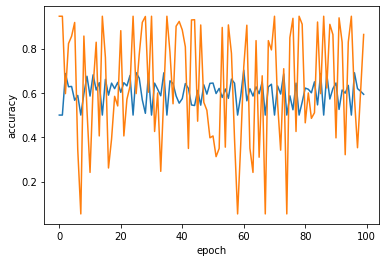

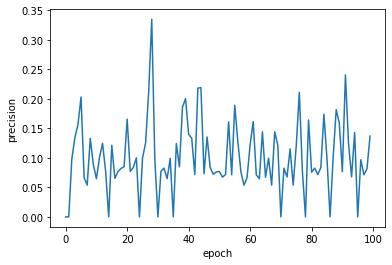

SGDClassifier(alpha=0.1, loss='perceptron')


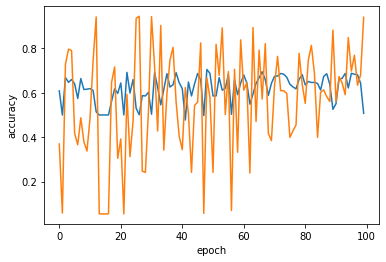

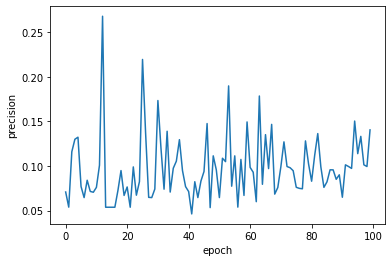

SGDClassifier(alpha=0.001, loss='perceptron', penalty=None)


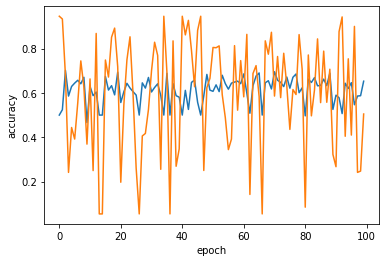

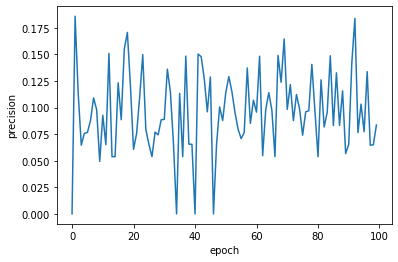

SGDClassifier(alpha=0.01, loss='perceptron', penalty='l1')


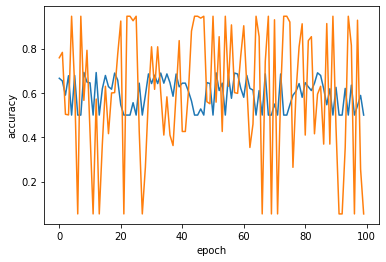

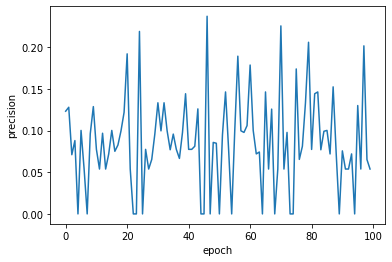

SGDClassifier(loss='perceptron', penalty='l1')


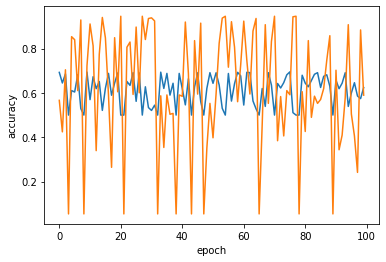

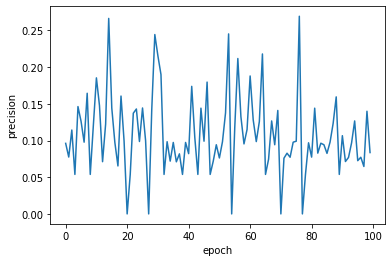

SGDClassifier(loss='squared_error', penalty='l1')


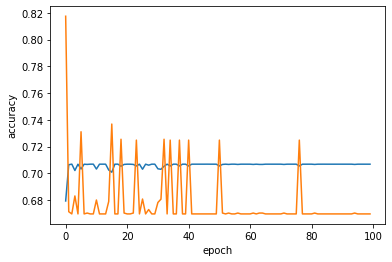

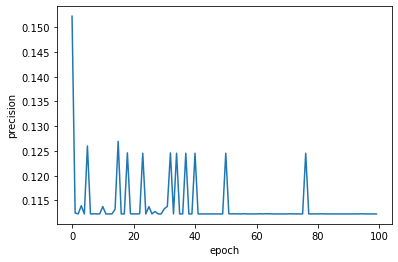

SGDClassifier(loss='modified_huber', penalty='elasticnet')


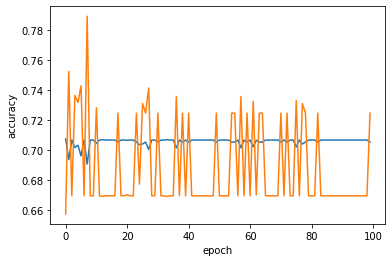

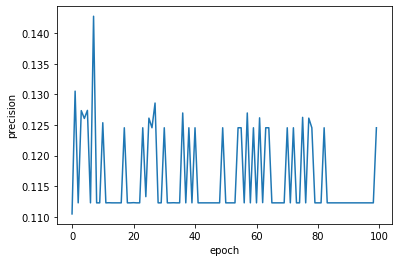

SGDClassifier(loss='modified_huber')


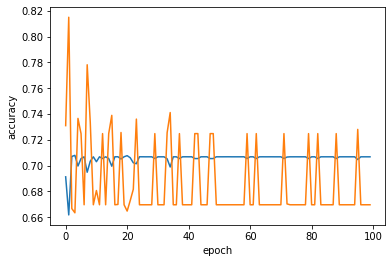

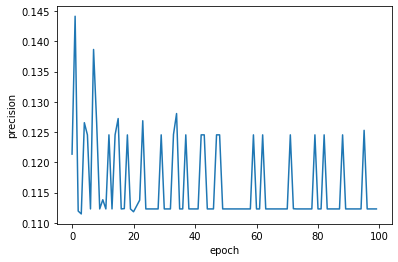

SGDClassifier(alpha=0.001, loss='squared_hinge', penalty='elasticnet')


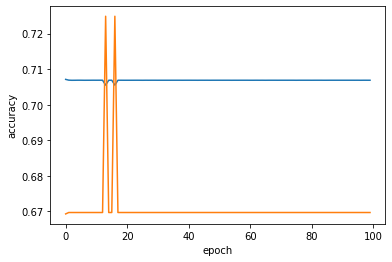

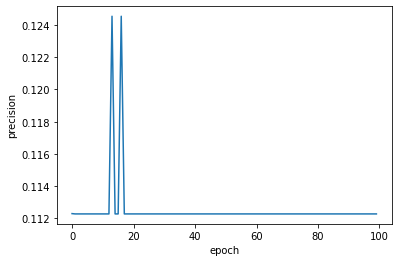

SGDClassifier(loss='squared_epsilon_insensitive', penalty='l1')


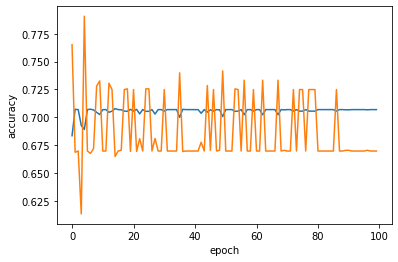

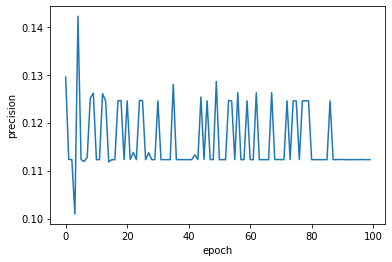

SGDClassifier(loss='squared_hinge', penalty='l1')


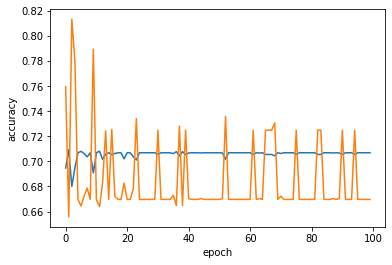

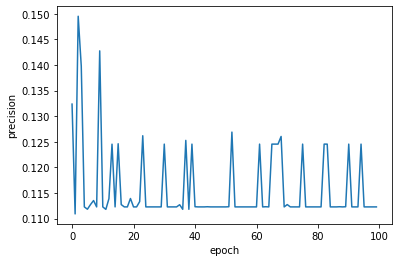

SGDClassifier(loss='log_loss', penalty=None)


ValueError: ignored

In [187]:
X_train, X_test, y_train, y_test = prepare_data_smote()

for model in sgd_temp["model"]:        
    train_score = []
    test_score = []
    precision = []

    classes = np.unique(y_train)
    
    model = eval(model)
    model.early_stopping = False
    
    print(model)
    for _ in range(0, 100):
        model.partial_fit(X_train, y_train, classes=classes)
        pred = model.predict(X_test)

        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))
        precision.append(precision_score(y_test, pred))
    
    plt.plot(train_score)
    plt.plot(test_score)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

    plt.plot(precision)
    plt.xlabel('epoch')
    plt.ylabel('precision')
    plt.show()

## SVM
- 종류
    - SVC
    - LinearSVC
    - NuSVC
    - https://scikit-learn.org/stable/modules/svm.html#svm-classification
- SVC 하이퍼 파라미터
    - C: float, default=1.0
    - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
    - degree: int, default=3
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’
    - coef0: float, default=0.0
    - shrinking: bool, default=True
    - probability: bool, default=False
    - tol: float, default=1e-3
    - cache_size: float, default=200
    - class_weight: dict or ‘balanced’, default=None
    - verbose: bool, default=False
    - max_iter: int, default=-1
    - decision_function_shape: {‘ovo’, ‘ovr’}, default=’ovr’
    - break_ties: bool, default=False

In [ ]:
from sklearn.svm import SVC, LinearSVC, NuSVC

model = SVC(max_iter=100, probability=True)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

### 모델링
- 하이퍼 파라미터
    - **kernel**: ```~```
        - "linear", "poly", "rbf", "sigmoid", "precomputed"
- 사용하지 않은 하이퍼 파라미터
    - C: float, default=1.0
    - degree: int, default=3
    - gamma: {‘scale’, ‘auto’} or float, default=’scale’
    - coef0: float, default=0.0
    - shrinking: bool, default=True
    - probability: bool, default=False
    - tol: float, default=1e-3
    - cache_size: float, default=200
    - class_weight: dict or ‘balanced’, default=None
    - verbose: bool, default=False
    - max_iter: int, default=-1
    - decision_function_shape: {‘ovo’, ‘ovr’}, default=’ovr’
    - break_ties: bool, default=False

In [ ]:
kernel_list = ["linear", "poly", "rbf", "sigmoid", "precomputed"]

svm_df = pd.DataFrame(columns=col_list)

X_train, X_test, y_train, y_test = prepare_data_smote()

for kernel in tqdm(kernel_list, desc="kernel"):
    svm_model = SVC(probability=True, max_iter=100,
                    kernel=kernel)
    svm_df = pd.concat([svm_df, make_eval_df(svm_model)], axis=0, ignore_index=True)

In [ ]:
svm_df.to_csv("./SVC_1.csv", index=False)

In [ ]:
params = {
    "C": [0, .01, .1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
    "class_weight": ["balanced", None],
}
# probability=True

X_train, X_test, y_train, y_test = prepare_data_smote()
model = SVC(probability=True, max_iter=100)
model_list, result = grid_search_eval(model, params)

0.0    286746
1.0    286746
Name: HEARTDISEASE, dtype: int64
0.0    71678
1.0     4052
Name: HEARTDISEASE, dtype: int64
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ..........C=0, class_weight=balanced, kernel=linear; total time=   0.1s
[CV] END ..........C=0, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END ..........C=0, class_weight=balanced, kernel=linear; total time=   0.0s
[CV] END ............C=0, class_weight=balanced, kernel=poly; total time=   0.0s
[CV] END ............C=0, class_weight=balanced, kernel=poly; total time=   0.0s
[CV] END ............C=0, class_weight=balanced, kernel=poly; total time=   0.0s
[CV] END .............C=0, class_weight=balanced, kernel=rbf; total time=   0.0s
[CV] END .............C=0, class_weight=balanced, kernel=rbf; total time=   0.0s
[CV] END .............C=0, class_weight=balanced, kernel=rbf; total time=   0.0s
[CV] END .........C=0, class_weight=balanced, kernel=sigmoid; total time=   0.0s
[CV] END

ValueError: X should be a square kernel matrix

             mean_test_precision  rank_test_precision
param_alpha                                          
0.0001                  0.227514           445.393519
0.0010                  0.226103           546.504630
0.0100                  0.222609           390.791667
0.1000                  0.209701           346.351852
                    mean_test_precision  rank_test_precision
param_class_weight                                          
0                              0.221449           407.719907
balanced                       0.221514           456.800926
                     mean_test_precision  rank_test_precision
param_learning_rate                                          
constant                        0.000000           579.145833
invscaling                      0.000000           573.854167
optimal                         0.664445           143.781250
                             mean_test_precision  rank_test_precision
param_loss                                          

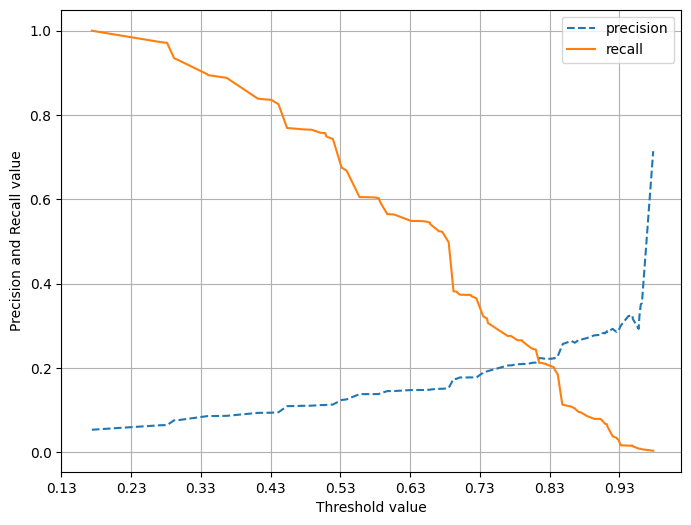

SGDClassifier(early_stopping=True, loss='squared_error')
SGDClassifier(alpha=0.001, early_stopping=True, loss='log_loss',
              penalty='elasticnet')


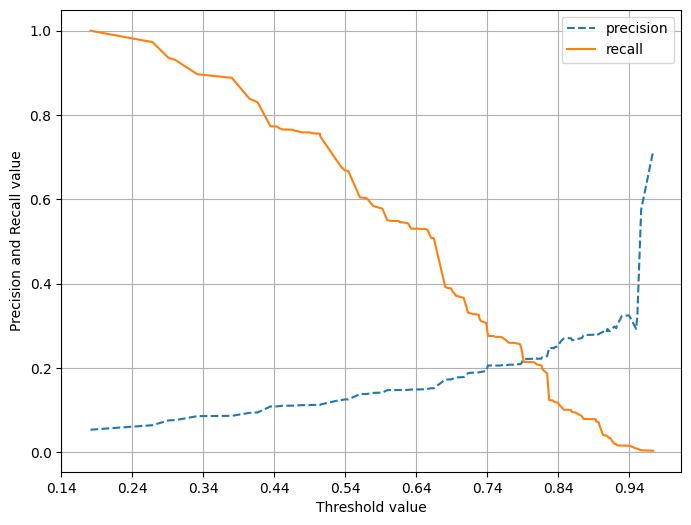

SGDClassifier(alpha=0.1, class_weight='balanced', early_stopping=True,
              loss='squared_hinge', penalty=None)
SGDClassifier(alpha=0.1, early_stopping=True, loss='log_loss', penalty=None)


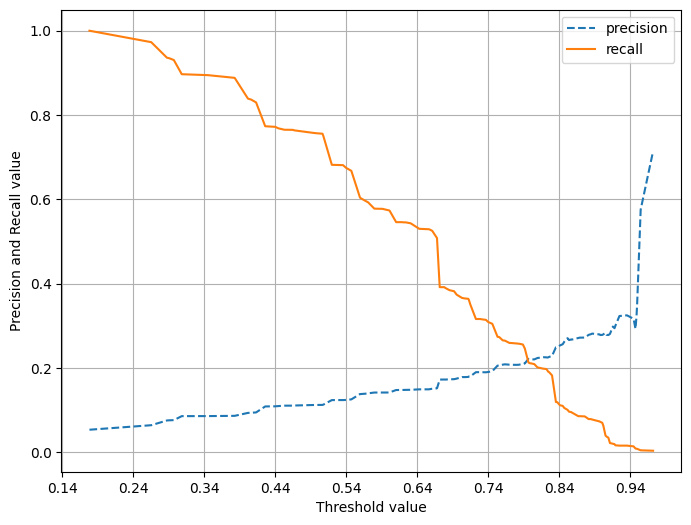

In [ ]:
check_result()

In [ ]:
params = {
    "nu": [0, .01, .1, 1],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
    "class_weight": ["balanced", None],
}
# probability=True

X_train, X_test, y_train, y_test = prepare_data_smote()
model = NuSVC(probability=True, max_iter=100)
model_list, result = grid_search_eval(model, params)

0.0    286743
1.0    286743
Name: HEARTDISEASE, dtype: int64
0.0    71681
1.0     4049
Name: HEARTDISEASE, dtype: int64
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END .........class_weight=balanced, kernel=linear, nu=0; total time=   0.0s
[CV] END .........class_weight=balanced, kernel=linear, nu=0; total time=   0.0s
[CV] END .........class_weight=balanced, kernel=linear, nu=0; total time=   0.0s


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......class_weight=balanced, kernel=linear, nu=0.01; total time= 5.7min


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......class_weight=balanced, kernel=linear, nu=0.01; total time= 5.6min


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ......class_weight=balanced, kernel=linear, nu=0.01; total time= 5.9min


D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END .......class_weight=balanced, kernel=linear, nu=0.1; total time=57.5min


In [ ]:
check_result()

In [ ]:
params = {
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "C": [0, .01, .1, 1, 10, 100],
    "class_weight": ["balanced", None],
}

X_train, X_test, y_train, y_test = prepare_data_smote()
model = LinearSVC(max_iter=100)
model_list, result = grid_search_eval(model, params)

In [ ]:
check_result()

# 서대훈

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

## LightGBM 

In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

# 손지호

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

## XGBClassifier

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

## KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)